In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
'''!pip install tensorflow==2.1.0
!pip install scipy
!pip install imgaug
!pip install pixellib --upgrade'''

'!pip install tensorflow==2.1.0\n!pip install scipy\n!pip install imgaug\n!pip install pixellib --upgrade'

In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Unet inputs
import tensorflow as tf

import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

# Root directory of the project
ROOT_DIR = os.getcwd()
if ROOT_DIR.endswith("samples/balloon"):
    # Go up two levels to the repo root
    ROOT_DIR = os.path.dirname(os.path.dirname(ROOT_DIR))

# Import Mask RCNN
sys.path.append(ROOT_DIR)
import utils
import visualize
from visualize import display_images

import curves

%matplotlib inline 

In [2]:
import os
from datetime import date
from datetime import datetime, timedelta
import pandas as pd, numpy as np
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
days_covered = 120
experiment_date_noTime = date.today()
output_folder = 'logs_naive/'+str(experiment_date_noTime)
os.makedirs(output_folder, exist_ok = True)
print('Output folder: ', output_folder)

Output folder:  logs_naive/2022-10-05


#### Load data

In [3]:
config = curves.CurveConfig()
CURVES_DIR = os.path.join(ROOT_DIR, "data/images/")
dataset = curves.CurveDataset()
dataset.load_curve(CURVES_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 1001
Class Count: 2
  0. BG                                                
  1. curve                                             


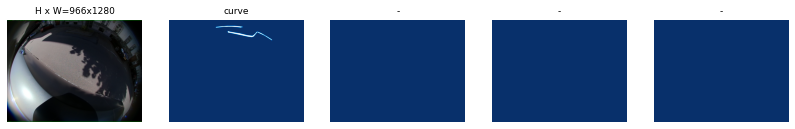

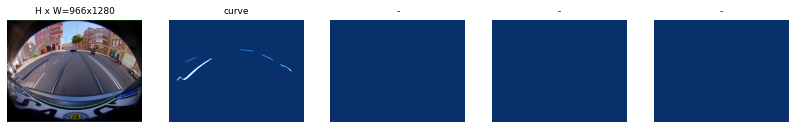

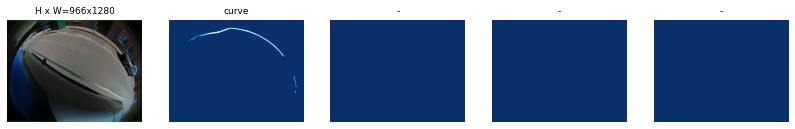

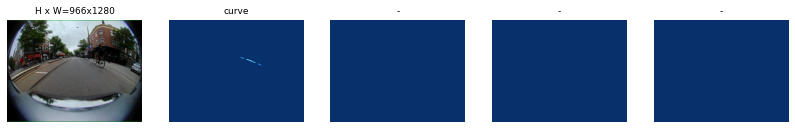

In [4]:
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [5]:
TYPE = 'FV'
image_list, mask_list = [], []
for info in dataset.image_info:
    if info['type'] == TYPE:
        image_list.append(info['path'])
        mask_list.append(info['mask_filename'])
    elif TYPE == 'ALL':
        image_list.append(info['path'])
        mask_list.append(info['mask_filename'])
print('Number of images: ', len(image_list))

Number of images:  280


In [6]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'c:\\Users\\borja\\Documents\\GitHub\\valeo_assessment\\data\\images\\train\\images\\00000_FV.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'c:\\Users\\borja\\Documents\\GitHub\\valeo_assessment\\data\\images\\train\\masks\\00000_FV.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'c:\\Users\\borja\\Documents\\GitHub\\valeo_assessment\\data\\images\\train\\images\\00001_FV.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'c:\\Users\\borja\\Documents\\GitHub\\valeo_assessment\\data\\images\\train\\masks\\00001_FV.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'c:\\Users\\borja\\Documents\\GitHub\\valeo_assessment\\data\\images\\train\\images\\00002_FV.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'c:\\Users\\borja\\Documents\\GitHub\\valeo_assessment\\data\\images\\train\\masks\\00002_FV.png'>)


In [7]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'c:\\Users\\borja\\Documents\\GitHub\\valeo_assessment\\data/images/train\\images\\00000_FV.png', shape=(), dtype=string)
tf.Tensor(b'c:\\Users\\borja\\Documents\\GitHub\\valeo_assessment\\data/images/train\\masks\\00000_FV.png', shape=(), dtype=string)


In [25]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.per_image_standardization(img)
    img = tf.image.convert_image_dtype(img, tf.float32) / 255
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.image.per_image_standardization(mask)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True) / 255
    
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (256, 256), method='nearest')
    input_mask = tf.image.resize(mask, (256, 256), method='nearest')
    
    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [26]:
def conv_block(inputs=None, n_filters=8, dropout_prob=0, max_pooling=False):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """
    conv = Conv2D(filters = n_filters, # Number of filters
                  kernel_size = 3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='GlorotNormal')(inputs)
    # conv = BatchNormalization()(conv)
    conv = Conv2D(filters = n_filters, # Number of filters
                  kernel_size = 3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='GlorotNormal')(conv)
    # conv = BatchNormalization()(conv)
    
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(rate = dropout_prob)(conv)
         
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = tf.keras.layers.MaxPool2D(
            pool_size=(2, 2)
        )(conv)
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [27]:
def upsampling_block(expansive_input, contractive_input, n_filters=8, stride = 1):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    up = Conv2DTranspose(
                 filters = n_filters,    # number of filters
                 kernel_size = 3,    # Kernel size
                 strides= stride,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(filters = n_filters,   # Number of filters
                 kernel_size = 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='GlorotNormal')(merge)
    conv = Conv2D(filters = n_filters,  # Number of filters
                 kernel_size = 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='GlorotNormal')(conv)    
    return conv

In [121]:
def unet_model(input_size=(96, 128, 3), n_filters=1, n_classes=1):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    cblock1 = conv_block(inputs, n_filters, max_pooling = True)
    cblock2 = conv_block(cblock1[0], n_filters * 1, max_pooling = False)
    cblock3 = conv_block(cblock2[0], n_filters * 2, max_pooling = False) #next_layer - same level but decing
    cblock4 = conv_block(cblock3[0], n_filters * 3, dropout_prob=0.3, max_pooling = False) 
    cblock5 = conv_block(cblock4[0], n_filters * 4, dropout_prob=0.3, max_pooling = False)
    
    # Expanding Path (decoding)
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters * 4, stride = 1)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters * 3, stride = 1)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters * 2, stride = 1)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters * 1, stride = 2)
    conv9 = Conv2D(filters = n_filters,
                 kernel_size = 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='GlorotNormal')(ublock9) # N(0,std = sqrt(2 / (_in + _out)))

    conv10 = Conv2D(filters = n_classes, kernel_size = 1, padding = 'same', activation='relu')(conv9)
    output_layer = tf.keras.layers.Activation(activation = 'sigmoid')(conv10)
    model = tf.keras.Model(inputs=inputs, outputs=output_layer)

    return model

In [122]:
img_height = 256
img_width = 256
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
unet.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_199 (Conv2D)             (None, 256, 256, 1)  28          input_14[0][0]                   
__________________________________________________________________________________________________
conv2d_200 (Conv2D)             (None, 256, 256, 1)  10          conv2d_199[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 128, 128, 1)  0           conv2d_200[0][0]                 
___________________________________________________________________________________________

In [124]:
## Penalization over fake negatives
def weighted_cross_entropy(beta):
    def loss(y_true, y_pred):
        weight_a = beta 
        weight_b = 1 - beta
    
        o =  - weight_a * (y_true * tf.math.log1p(tf.abs(y_pred))) + (-weight_b)* (1 - y_true)*tf.math.log1p(tf.abs(y_pred))
        return tf.reduce_mean(o)
    return loss

def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score


def dice_coeff_loss(y_true, y_pred):
    return 1.0 - dice_coeff(y_true, y_pred)

# Read this suggestion of not using only dice_coeff for loss functions 
def bce_dice_loss(y_true, y_pred):
    return tf.keras.metrics.binary_crossentropy(y_true, y_pred) + dice_coeff_loss(y_true, y_pred)

from keras.optimizers import Adam
# tf.keras.metrics.MeanIoU(2)
# unet.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=[tf.keras.metrics.MeanIoU(2)])
# unet.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics = ['accuracy'])
# unet.compile(optimizer = 'adam', loss = bce_dice_loss, metrics = [tf.keras.metrics.MeanIoU(2)])#tf.keras.metrics.MeanIoU(2)])
unet.compile(optimizer = 'adam', loss=bce_dice_loss, metrics=[dice_coeff, tf.keras.metrics.MeanIoU(num_classes=2)])

In [125]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    if len(display_list) > 2:
        print(np.unique(display_list[2].numpy()))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(966, 1280, 1)
(966, 1280, 1)
(966, 1280, 1)
(966, 1280, 1)
(966, 1280, 1)


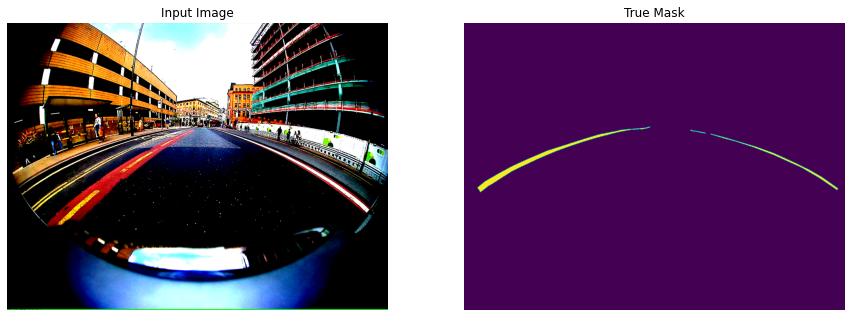

In [126]:
for image, mask in image_ds.take(5):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)


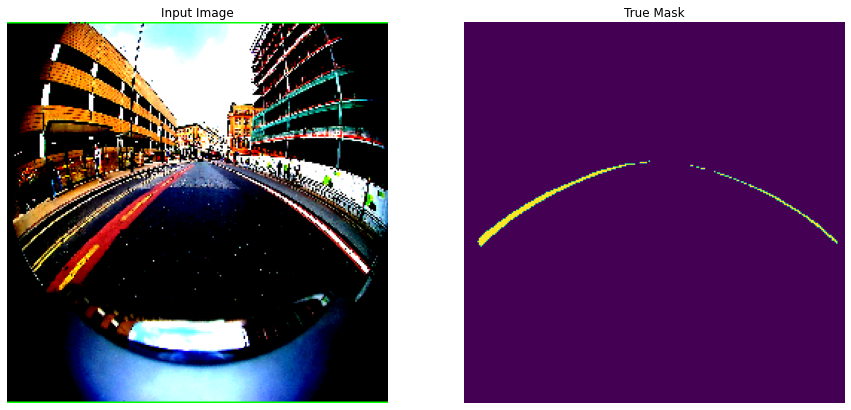

In [127]:
for image, mask in processed_image_ds.take(5):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [128]:
EPOCHS = 2
BUFFER_SIZE = 500
BATCH_SIZE = 300
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None))
Train for 1 steps
Epoch 1/2
1/1 [==============================] - 39s 39s/step - loss: 1.6804 - dice_coeff: 0.0128 - mean_io_u_19: 0.4968
Epoch 2/2
1/1 [==============================] - 17s 17s/step - loss: 1.6804 - dice_coeff: 0.0128 - mean_io_u_19: 0.4968


In [129]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]
model_history.history

{'loss': [1.6803733110427856, 1.6803733110427856],
 'dice_coeff': [0.012774481, 0.012774481],
 'mean_io_u_19': [0.49676502, 0.49676502]}

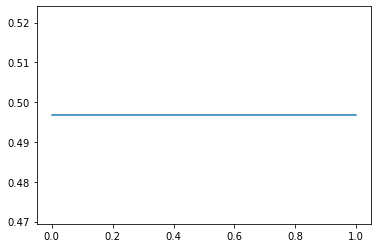

In [111]:
plt.plot(model_history.history["mean_io_u_19"])

In [112]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

[0]


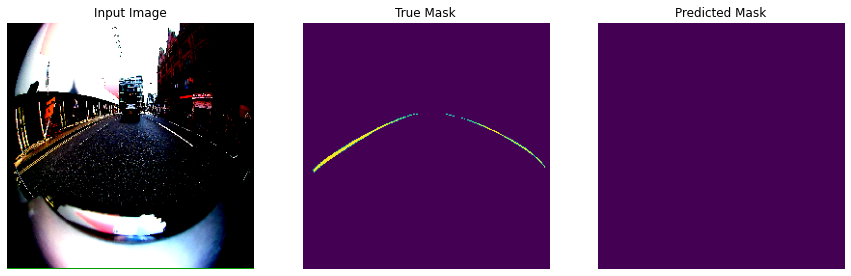

In [113]:
show_predictions(train_dataset, 10)

#### VGG16 - pretrained model

In [ ]:
from keras.applications import vgg16
from keras.models import Model,load_model
import pandas as pd
from keras.layers import Input, Conv2D, Conv2DTranspose,AveragePooling2D, MaxPooling2D,UpSampling2D,LeakyReLU, concatenate, Dropout,BatchNormalization,Activation
from keras.callbacks import EarlyStopping,ModelCheckpoint
import pandas as pd
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from numpy.random import seed
seed(123)
import tensorflow as tf
tf.random.set_seed(6543210)
from keras import backend as K

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
 
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    return x
 
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x
 
def build_vgg16_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)
 
    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)
    
    set_trainable = False
    for layer in vgg16.layers:
        if layer.name in ['block1_conv1']:
            set_trainable = True
        # Frozen layers
        if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
            layer.trainable = False


 
    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)
 
    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)
 
    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)
 
    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
 
    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

In [22]:
input_shape = (128, 128, 3)
Model_ = build_vgg16_unet(input_shape)
Model_.summary()

Model: "VGG16_U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 512, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 512, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 256, 64) 0           block1_conv2[0][0]               
________________________________________________________________________________________

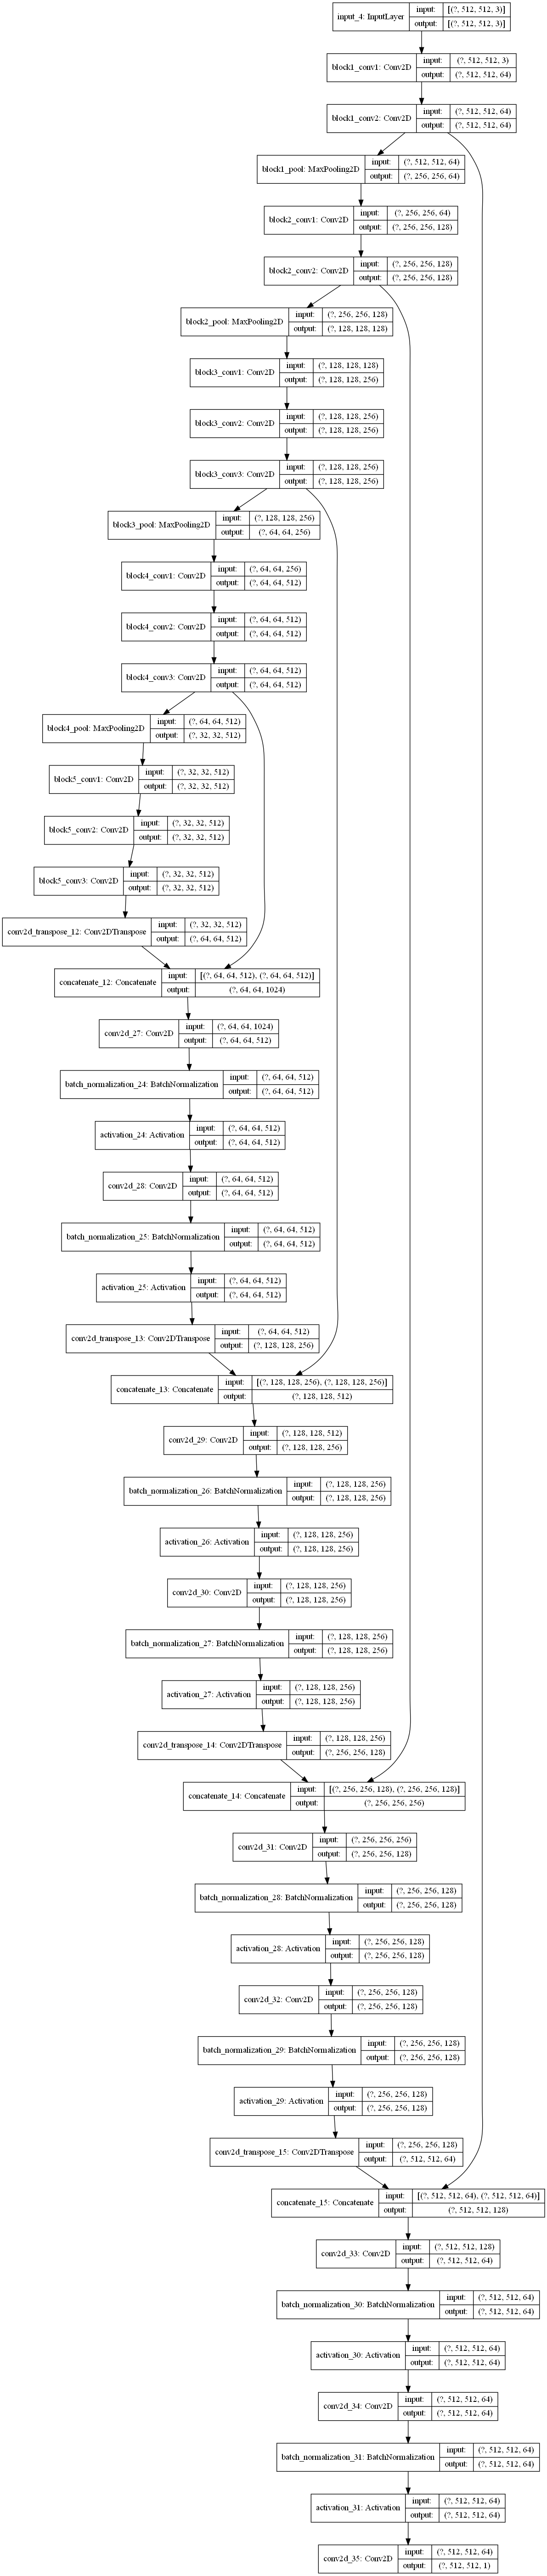

In [23]:
from keras.utils import plot_model
tf.keras.utils.plot_model(Model_,to_file='model_.png',show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_.png')

In [24]:
Model_.compile(optimizer = "Adam", loss = 'binary_crossentropy', metrics = ['accuracy'])

In [25]:
checkpointer = ModelCheckpoint('valeo_UNET.h5', verbose=1,mode='auto', monitor='loss',save_best_only=True)

#### Train and check

In [29]:
import os
from datetime import date
from datetime import datetime, timedelta
import pandas as pd, numpy as np
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
days_covered = 120
experiment_date_noTime = date.today()
output_folder = 'logs_VGG16/'+str(experiment_date_noTime)
os.makedirs(output_folder, exist_ok = True)
print('Output folder: ', output_folder)

Output folder:  logs_VGG16/2022-10-04


In [35]:
config = curves.CurveConfig()
CURVES_DIR = os.path.join(ROOT_DIR, "data/images/")
dataset = curves.CurveDataset()
dataset.load_curve(CURVES_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 1001
Class Count: 2
  0. BG                                                
  1. curve                                             


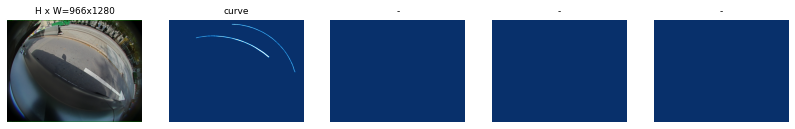

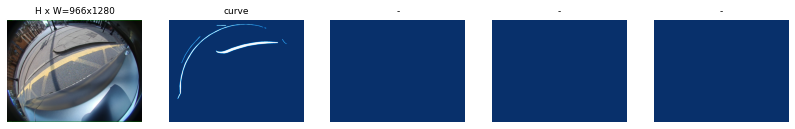

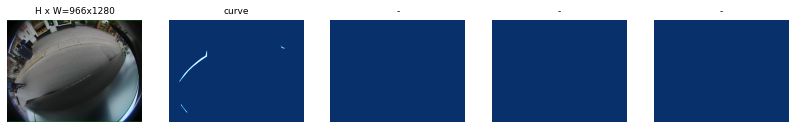

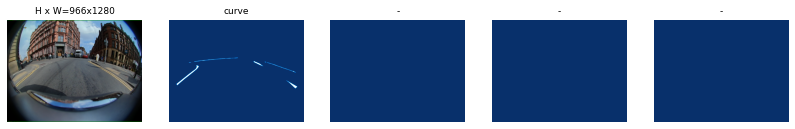

In [36]:
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [37]:
image_list = [info['path'] for info in dataset.image_info]
mask_list = [info['mask_filename'] for info in dataset.image_info]
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)
    
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)
    
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True) / 255
    
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (128, 128), method='nearest')
    input_mask = tf.image.resize(mask, (128, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

(<tf.Tensor: shape=(), dtype=string, numpy=b'c:\\Users\\borja\\Documents\\GitHub\\valeo_assessment\\data\\images\\train\\images\\00000_FV.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'c:\\Users\\borja\\Documents\\GitHub\\valeo_assessment\\data\\images\\train\\masks\\00000_FV.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'c:\\Users\\borja\\Documents\\GitHub\\valeo_assessment\\data\\images\\train\\images\\00001_FV.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'c:\\Users\\borja\\Documents\\GitHub\\valeo_assessment\\data\\images\\train\\masks\\00001_FV.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'c:\\Users\\borja\\Documents\\GitHub\\valeo_assessment\\data\\images\\train\\images\\00002_FV.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'c:\\Users\\borja\\Documents\\GitHub\\valeo_assessment\\data\\images\\train\\masks\\00002_FV.png'>)
tf.Tensor(b'c:\\Users\\borja\\Documents\\GitHub\\valeo_assessment\\data/images/train\\images\\00000_FV.png', shape=(), dtype=string)
tf.

In [38]:
EPOCHS = 10
BUFFER_SIZE = 1000
BATCH_SIZE = 100
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

model_history = Model_.fit(train_dataset, epochs=EPOCHS)

Train for 11 steps
Epoch 1/10


: 

: 